# DinoV3 based Segmentation model

This notebook show the experiments we conducted to train a custom model using DinoV3 as an encoder to produce Glacier occupancy maps.

## Imports and setup

In [ ]:
%load_ext autoreload
%autoreload 2 
import numpy as np
import pandas as pd
import torch, os, wandb
from tqdm.auto import tqdm
import torch.nn.functional as F  
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset
from huggingface_hub import notebook_login

# Check the HF credentials
notebook_login(new_session=False)
# Same for wandb
wandb.login()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


wandb: Currently logged in as: jeremy-hugentobler (jeremy-hugentobler-epfl) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [ ]:

# Model IMPORTS
from models.DinoV3.SemanDino import GlacierSegmenter
from models.DinoV3.GlacierDataset import GlacierDataset
import segmentation_models_pytorch as smp
from models.UNET.utils.train import initialize_Unet

# Utils import
from models.utils.metrics import get_combined_loss, get_iou_metric
from models.utils.training import train_one_epoch, validate_one_epoch

# constants
IGNORE_INDEX = 255
NUM_CLASS = 2
BATCH_SIZE = 8
MAX_EPOCHS = 50
PATIENCE = 7
MIN_DELTA = 0.002 # Minimum change to qualify as an improvement in the pateince mechanism
N_SPLITS = 5
NUM_WORKERS = 2

# HYPERPARAMETERS TUNING
LRS = [1e-3, 1e-4, 1e-5]
LOSS_WEIGHTS = [(0.5, 0.5), (0.7, 0.3), (0.3, 0.7), (1, 0), (0, 1)]  # (CE weight, Dice weight)

# Models to do the test on
models = ['U-NET', 'DinoV3']  # You can add more model names
model_name = models[1]  

# Paths
TRAIN_IMAGE_DIR = "dataset/clean/images/"
TRAIN_MASK_DIR = "dataset/clean/masks/"
TEST_IMAGE_DIR = "dataset/test/images/"
TEST_MASK_DIR = "dataset/test/masks/"
CHECKPOINT_DIR = "checkpoints/"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on: {device}")

# Dataset
full_train_ds = GlacierDataset(
    image_dir="dataset/clean/images/",
    mask_dir="dataset/clean/masks/",
    mode="train",
)

train_ds_for_val = GlacierDataset(
    image_dir=TRAIN_IMAGE_DIR,
    mask_dir=TRAIN_MASK_DIR,
    mode="test" # -> this disables data augmentation on the validation set
)

# K-Fold + Cross Validation
kfold = KFold(n_splits=N_SPLITS, shuffle=True, random_state=42)

# Collects all CV results if needed later
results = []

for lr in LRS:
    for ce_weight, dice_weight in LOSS_WEIGHTS:
        
        # Global experiment settings
        config_tag = f"{model_name}_LR{lr}_CE{ce_weight}_Dice{dice_weight}"
        saved_dir = os.path.join(CHECKPOINT_DIR, f"{model_name}_{config_tag}")
        os.makedirs(saved_dir, exist_ok=True)
        
        # Metrics for each fold
        fold_best_ious = []
        fold_best_epochs = []
        fold_ckpts = []
        
        print("-"*50, f"\n CONFIG: lr={lr}, ce={ce_weight}, dice={dice_weight} \n", "-"*50)
        
        # K-Fold Cross Validation
        for fold, (train_ids, val_ids) in enumerate(kfold.split(full_train_ds), start = 1):
            
            run = wandb.init(
                project=f"Glacier_Segmentation_{model_name}",
                group=f"{config_tag}",
                name=f"fold_{fold}",
                config={
                    "lr": lr,
                    "ce_weight": ce_weight,
                    "dice_weight": dice_weight,
                    "batch_size": BATCH_SIZE,
                    "max_epochs": MAX_EPOCHS,
                    "patience": PATIENCE,
                    "min_delta": MIN_DELTA,
                    "n_splits": N_SPLITS,
                    "num_workers": NUM_WORKERS,
                    "ignore_index": IGNORE_INDEX,
                    "num_classes": NUM_CLASS,
                },
                reinit=True
            )
            
            # Metrics
            criterion = get_combined_loss(ce_weight, dice_weight, ignore_index=IGNORE_INDEX)
            iou_metric = get_iou_metric(ignore_index=IGNORE_INDEX)
            
            # Initialize model
            if model_name == 'U-NET':
                model = initialize_Unet(classes=NUM_CLASS).to(device)
            elif model_name == 'DinoV3':
                model = GlacierSegmenter(num_classes=NUM_CLASS).to(device)
            else:
                raise ValueError(f"Model {model_name} not recognized.")
            
            params_to_update = filter(lambda p: p.requires_grad, model.parameters())
            optimizer = torch.optim.AdamW(params_to_update, lr=lr)
            
            # Sample elements randomly from a given list of ids, no replacement.
            train_subsampler = Subset(full_train_ds, train_ids)
            val_subsampler = Subset(train_ds_for_val, val_ids)
            
            # data loaders for training and validation
            train_loader = DataLoader(
                train_subsampler,
                batch_size=BATCH_SIZE,
                shuffle=True,
                num_workers=NUM_WORKERS,
                pin_memory=True,
                drop_last=True,
                persistent_workers=True,  
                prefetch_factor=4
            )
            
            val_loader = DataLoader(
                val_subsampler,
                batch_size=BATCH_SIZE,
                shuffle=False,
                num_workers=NUM_WORKERS,
                pin_memory=True,
                drop_last=False,
                persistent_workers=True,  
                prefetch_factor=4
            )
            
            # Training Loop with Early Stopping
            best_val_iou = -1.0
            best_epoch = -1
            best_ckpt_path = os.path.join(saved_dir, f"best_model_fold_{fold}.pth")
            no_improve_epochs = 0      
            
            epoch_pbar = tqdm(range(1, MAX_EPOCHS + 1), desc=f"[{config_tag}] Fold {fold}", leave=False)      
            for epoch in epoch_pbar:
                
                # Train
                train_loss = train_one_epoch(
                    model, train_loader, optimizer, criterion, device
                )
                
                # Validation
                val_loss, val_iou = validate_one_epoch(
                    model, val_loader, criterion, iou_metric, device
                )
                
                # Logging
                run.log({
                    "epoch": epoch,
                    "train/loss": float(train_loss),
                    "val/loss": float(val_loss),
                    "val/iou": float(val_iou),
                })
                # Internal progress bar update
                epoch_pbar.set_postfix({
                    "T_Loss": f"{train_loss:.3f}",
                    "V_Loss": f"{val_loss:.3f}",
                    "V_IoU": f"{val_iou:.3f}",
                    "Best": f"{best_val_iou:.3f}" if best_val_iou >= 0 else "NA",
                })
                
                # Save Best Model
                if val_iou > best_val_iou + MIN_DELTA:
                    best_val_iou = val_iou
                    best_epoch = epoch
                    no_improve_epochs = 0  # reset counter
                    torch.save(
                        model.state_dict(),
                        best_ckpt_path
                    )   
                else:
                    no_improve_epochs += 1
                # Early Stopping
                if no_improve_epochs >= PATIENCE:
                    run.log({"early_stop/epoch": epoch})
                    break
            # For this fold
            run.log({
                "fold/best_iou": best_val_iou,
                "fold/best_epoch": best_epoch,
            })
            run.finish()
            
            
            # Local record keeping
            fold_best_ious.append(best_val_iou)
            fold_best_epochs.append(best_epoch)
            fold_ckpts.append(best_ckpt_path)
        # After all folds -> we do the stats
        mean_iou = float(np.mean(fold_best_ious)) if fold_best_ious else float("nan")
        std_iou = float(np.std(fold_best_ious)) if fold_best_ious else float("nan")
        median_epoch = int(np.median(fold_best_epochs)) if fold_best_epochs else -1
        
        results.append({
            "lr": lr,
            "ce_weight": ce_weight,
            "dice_weight": dice_weight,
            "mean_best_iou": mean_iou,
            "std_best_iou": std_iou,
            "median_best_epoch": median_epoch,
            "fold_best_ious": fold_best_ious,
            "fold_best_epochs": fold_best_epochs,
            "fold_ckpts": fold_ckpts,
            "config_tag": config_tag,
            "saved_dir": saved_dir,
        })
        
        df = pd.DataFrame(results).sort_values("mean_best_iou", ascending=False)
        df.to_csv(os.path.join(CHECKPOINT_DIR, f"{model_name}_cv_results.csv"), index=False)

df = pd.DataFrame(results).sort_values("mean_best_iou", ascending=False)
print("\nTop configs:")
print(df[["lr", "ce_weight", "dice_weight", "mean_best_iou", "std_best_iou", "median_best_epoch", "config_tag"]].head(10))

best = df.iloc[0].to_dict()
print("\nBEST CONFIG:", best)
        

Training on: cuda
FOLD 1
------------------------------


Fold 1 Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/55 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/55 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/55 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/55 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/55 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/55 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/55 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/55 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/55 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/55 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

FOLD 1: Best val IoU : 0.8262
FOLD 2
------------------------------


Fold 2 Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/55 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/55 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/55 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/55 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/55 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/55 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76096155d1c0>
Traceback (most recent call last):
  File "/opt/jlab-env-3.12.8/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76096155d1c0>
Traceback (most recent call last):
  File "/opt/jlab-env-3.12.8/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/opt/jlab-env-3.12.8/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1550, in _shutdown_workers
    self._pin_memory_thread.join()
  File "/opt/jlab-env-3.12.8/lib/python3.12/threading.py", line 1146, in join
    raise RuntimeError("cannot join current thread")
RuntimeError: cannot join current thread
    self._shutdown_workers()
  File "/opt/jlab-env-3.12.8/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_a

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/55 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/55 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/55 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/55 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76096155d1c0>
Traceback (most recent call last):
  File "/opt/jlab-env-3.12.8/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/opt/jlab-env-3.12.8/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/opt/jlab-env-3.12.8/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76096155d1c0>
Traceback (most recent call last):
  File "/opt/jlab-env-3.12.8/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/opt/jlab-env-3.12.8/lib/python3.1

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76096155d1c0>
Traceback (most recent call last):
  File "/opt/jlab-env-3.12.8/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/opt/jlab-env-3.12.8/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/opt/jlab-env-3.12.8/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x76096155d1c0>^
^Traceback (most recent call last):
^  File "/opt/jlab-env-3.12.8/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
^^    ^self._shutdown_workers()^^
^  File "/opt/jlab-env-3.12.8/lib/python3.12/site-packages/torch/utils/data/dataloader.py", 

FOLD 2: Best val IoU : 0.8430
FOLD 3
------------------------------


Fold 3 Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/55 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/55 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/55 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/55 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/55 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/55 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/55 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/55 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/55 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/55 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

FOLD 3: Best val IoU : 0.8354
FOLD 4
------------------------------


Fold 4 Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/55 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/55 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/55 [00:00<?, ?it/s]

Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x76096155d1c0>
Traceback (most recent call last):
  File "/opt/jlab-env-3.12.8/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
self._shutdown_workers()
  File "/opt/jlab-env-3.12.8/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
    Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x76096155d1c0> 
 Traceback (most recent call last):
^  File "/opt/jlab-env-3.12.8/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
^^    ^self._shutdown_workers()^
^  File "/opt/jlab-env-3.12.8/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
^^    ^if w.is_alive():^
^ ^ 
   File "/opt/jlab-env-3.12.8/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/55 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/55 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/55 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76096155d1c0>
Traceback (most recent call last):
  File "/opt/jlab-env-3.12.8/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/opt/jlab-env-3.12.8/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
     Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x76096155d1c0> 
^Traceback (most recent call last):
^  File "/opt/jlab-env-3.12.8/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
^^    ^self._shutdown_workers()^
^  File "/opt/jlab-env-3.12.8/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
^^    ^if w.is_alive():^
^ 
   File "/opt/jlab-env-3.12.8/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test 

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/55 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/55 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/55 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76096155d1c0>
Traceback (most recent call last):
  File "/opt/jlab-env-3.12.8/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/opt/jlab-env-3.12.8/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x76096155d1c0> 
 Traceback (most recent call last):
    File "/opt/jlab-env-3.12.8/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
       self._shutdown_workers()^
^  File "/opt/jlab-env-3.12.8/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
^^    ^if w.is_alive():^
^ ^ ^ ^ ^ ^ 
   File "/opt/jlab-env-3.12.8/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
^    ^assert self._parent_pid == os.getpid(), 'can only 

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/55 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

FOLD 4: Best val IoU : 0.8447
FOLD 5
------------------------------


Fold 5 Progress:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/55 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/55 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/55 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/55 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/55 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76096155d1c0>
Traceback (most recent call last):
  File "/opt/jlab-env-3.12.8/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/opt/jlab-env-3.12.8/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/opt/jlab-env-3.12.8/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76096155d1c0>
Traceback (most recent call last):
  File "/opt/jlab-env-3.12.8/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/opt/jlab-env-3.12.8/lib/python3.1

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76096155d1c0>
Traceback (most recent call last):
  File "/opt/jlab-env-3.12.8/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/opt/jlab-env-3.12.8/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x76096155d1c0>^
^Traceback (most recent call last):
^  File "/opt/jlab-env-3.12.8/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
^^    ^self._shutdown_workers()^
^  File "/opt/jlab-env-3.12.8/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
^^    ^if w.is_alive():

  File "/opt/jlab-env-3.12.8/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      assert self._parent_pid == os.getpid(), 'can only test a 

Training:   0%|          | 0/55 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/55 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/55 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Training:   0%|          | 0/55 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76096155d1c0>
Traceback (most recent call last):
  File "/opt/jlab-env-3.12.8/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/opt/jlab-env-3.12.8/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/opt/jlab-env-3.12.8/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x76096155d1c0>
Traceback (most recent call last):
  File "/opt/jlab-env-3.12.8/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/opt/jlab-env-3.12.8/lib/python3.1

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x76096155d1c0>IOStream.flush timed out
IOStream.flush timed out

  File "/opt/jlab-env-3.12.8/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
    self._shutdown_workers()
  File "/opt/jlab-env-3.12.8/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
    if w.is_alive():
 Exception ignored in:    <function _MultiProcessingDataLoaderIter.__del__ at 0x76096155d1c0>  
 Traceback (most recent call last):
^  File "/opt/jlab-env-3.12.8/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1604, in __del__
^^    self._shutdown_workers()^
^  File "/opt/jlab-env-3.12.8/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1587, in _shutdown_workers
^    ^if w.is_alive():^
^ ^ ^ ^ 
   File "/opt/jlab-env-3.12.8/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
      as

Training:   0%|          | 0/55 [00:00<?, ?it/s]

Validation:   0%|          | 0/14 [00:00<?, ?it/s]

FOLD 5: Best val IoU : 0.8473


In [7]:
from models.utils.inference import run_eval

BEST_FOLD_ID = 5
BEST_MODEL_WEIGHTS = f"checkpoints/best_model_fold_{BEST_FOLD_ID}.pth"
best_model = GlacierSegmenter(num_classes=NUM_CLASS).to(device)

best_model.load_state_dict(torch.load(BEST_MODEL_WEIGHTS, map_location=device))

# Test set evaluation
test_dataset = GlacierDataset(
    image_dir=TEST_IMAGE_DIR,
    mask_dir=TEST_MASK_DIR,
    mode="test"
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS, 
    pin_memory=True
)

print(f"Evaluating on the test set with : {len(test_dataset)} images")

# Metrics setup
criterion = get_combined_loss(0.5, 0.5, ignore_index=IGNORE_INDEX)
iou_metric = get_iou_metric(ignore_index=IGNORE_INDEX)

# Using the function we created in the utils for modularity
test_loss, test_iou, saved_imgs, saved_masks, saved_preds = run_eval(
    best_model, 
    test_loader, 
    criterion=criterion, 
    iou_metric=iou_metric, 
    return_preds=True,
    device=device
)

# Résultats
print("\n" + "="*40)
print(f"RESULTS (Fold {BEST_FOLD_ID})")
print("="*40)
print(f"Test Loss : {test_loss:.4f}")
print(f"Test IoU  : {test_iou:.4f} ({(test_iou*100):.2f}%)")
print("="*40)

/tmp/ipykernel_2223/805077801.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(BEST_MODEL_WEIGHTS, map_location=device))


Evaluating on the test set with : 185 images


Inference:   0%|          | 0/24 [00:00<?, ?it/s]


RESULTS (Fold 5)
Test Loss : 0.2561
Test IoU  : 0.7734 (77.34%)


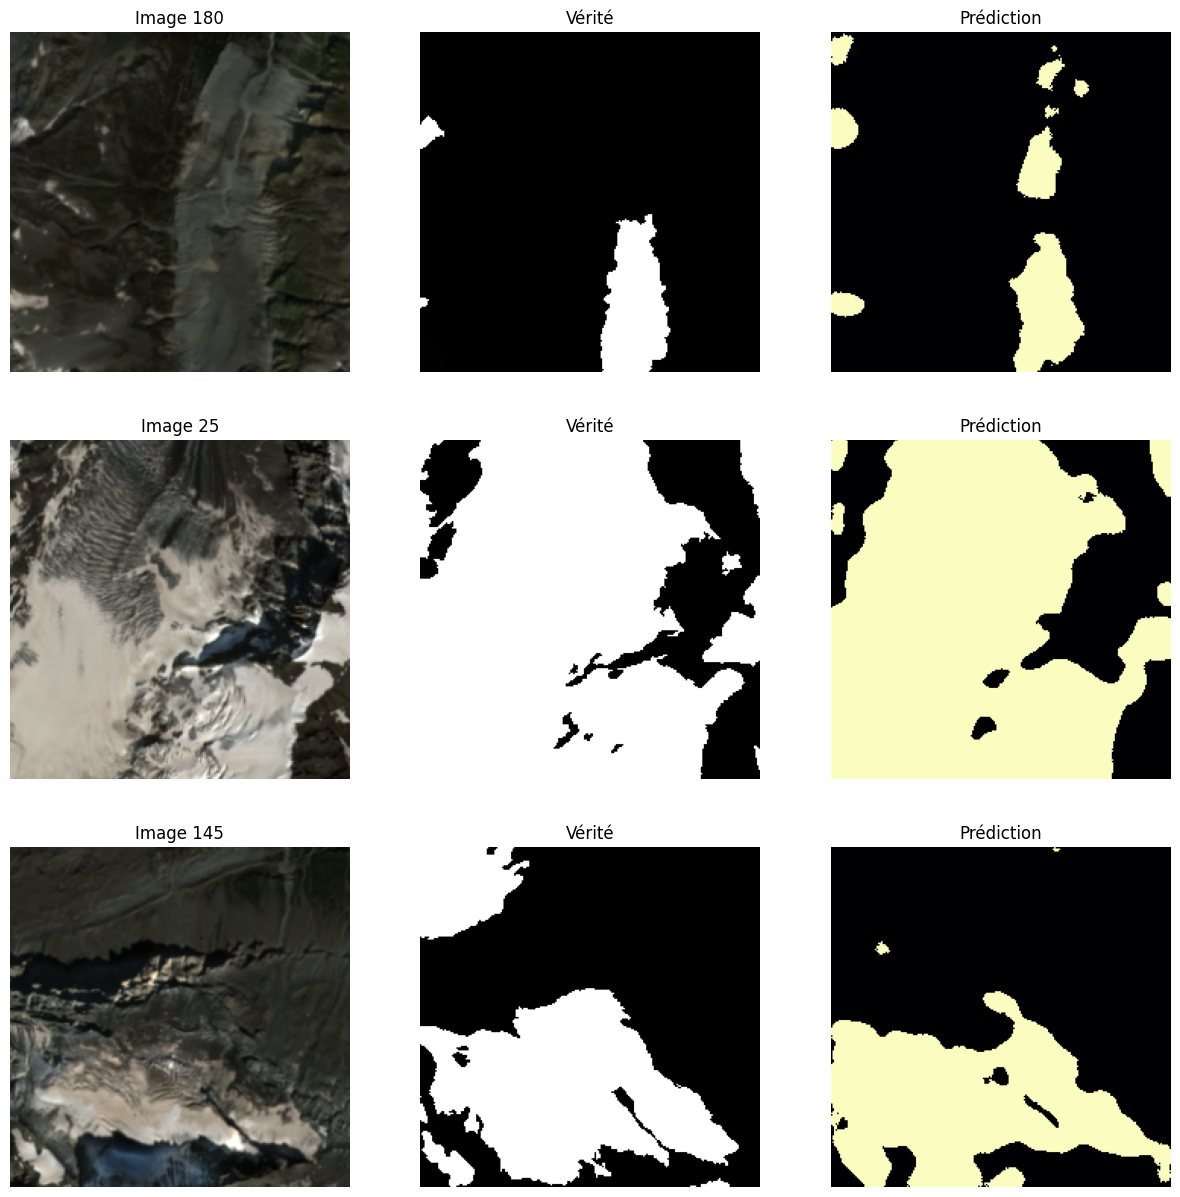

In [12]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import random

# 1. Fonction pour remettre les couleurs normales (Dénormalisation Dino)
def denormalize(tensor):
    """Inverse la normalisation pour l'affichage RGB."""
    # Stats utilisées dans ton Dataset
    mean = torch.tensor([0.430, 0.411, 0.296]).view(3, 1, 1)
    std = torch.tensor([0.213, 0.156, 0.143]).view(3, 1, 1)
    
    # On inverse : image * std + mean
    img = tensor.cpu() * std + mean
    
    # On passe de (C, H, W) à (H, W, C) pour Matplotlib
    img = img.permute(1, 2, 0).numpy()
    
    # On clip entre 0 et 1 pour éviter les pixels aberrants
    return np.clip(img, 0, 1)

# 2. Configuration de l'affichage

indices = random.sample(range(len(saved_imgs)), 3)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, idx in enumerate(indices):
    # Image
    axes[i, 0].imshow(denormalize(saved_imgs[idx]))
    axes[i, 0].set_title(f"Image {idx}")
    axes[i, 0].axis('off')
    
    # Masque
    axes[i, 1].imshow(saved_masks[idx].cpu(), cmap='gray')
    axes[i, 1].set_title("Vérité")
    axes[i, 1].axis('off')
    
    # Pred
    axes[i, 2].imshow(saved_preds[idx].cpu(), cmap='magma')
    axes[i, 2].set_title("Prédiction")
    axes[i, 2].axis('off')

plt.show()